# Data Preprocessing

The raw data comes from the [Orcasound Project](https://www.orcasound.net/). We will use the annotated portion (annotated by Scott Veirs) to create a dataset for classification, which will lend itself to other tasks as well (cocktail party problem, etc).

The raw dataset consists of a 30 minute wav recording with annotations in a txt file that can be downloaded using the aws cli and the following command: `aws --no-sign-request s3 cp s3://acoustic-sandbox/labeled-data/classification/killer-whales/global-general . --recursive`

In [45]:
annotations = []

with open('orcasound-lab/test-only/OS_7_05_2019_08_24_00_labels-SV_200210_only_calls.txt') as file:
    for line in file.readlines():
        if line[0] == '\\': continue
        start_offset, end_offset, _ = line.split() # offsets are in seconds
        annotations.append((float(start_offset), float(end_offset)))

Number of annotations:

In [46]:
len(annotations)

398

Max length of a call:

In [52]:
max([a2 - a1 for a1, a2 in annotations])

3.6105590000000802

Let's extract the calls as 4 second audio excerpts. We will slice the recording into 398 positive examples and however many negative examples we will be able to create.

In [65]:
audio, sr = librosa.core.load('orcasound-lab/test-only/OS_7_05_2019_08_24_00_.wav')

Recording duration in minutes:

In [66]:
audio.shape[0] // sr / 60

30.0

Sampling rate of the recording:

In [59]:
sr

22050

In [64]:
annotations = sorted(annotations, key=lambda x: x[0]) # just making sure the annotations are indeed sorted

In [84]:
positive_examples = []

for start, end in annotations:
    mid = start + (end - start) / 2
    mid_offset = mid * sr
    start_offset = mid_offset - 2 * sr
    end_offset = mid_offset + 2 * sr
    positive_examples.append(audio[int(start_offset):int(end_offset)])

Let's see what we got.

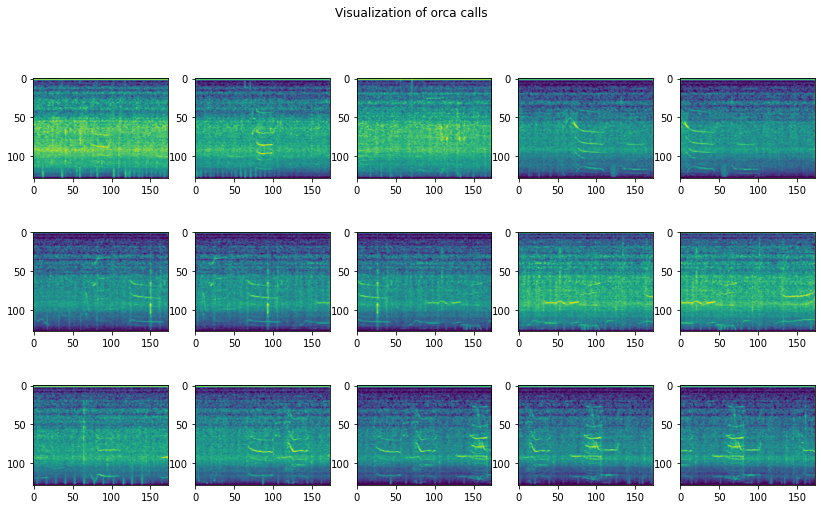

In [133]:
features = []
for i in range(15):
    spec = librosa.feature.melspectrogram(positive_examples[i], sr=sr)
    spec_db = librosa.core.amplitude_to_db(spec)
    features.append(spec_db)

fig, subplots = plt.subplots(3, 5, figsize=(14,8))
for feature, subplot in zip(features, subplots.flatten()):
    subplot.imshow(feature)
    
plt.suptitle('Visualization of orca calls');

Now let's grab negative examples.

In [107]:
segments = []

prev_end_offset = 0
for start, end in annotations:
    start_offset = int(start*sr)
    end_offset = int(end*sr)
    
    segments.append(audio[prev_end_offset:start_offset])
    prev_end_offset = end_offset
    
negative_examples = []

for segment in segments:
    while segment.shape[0] >= 4*sr:
        negative_examples.append(segment[:4*sr])
        segment = segment[4*sr:]

In [132]:
len(negative_examples)

196

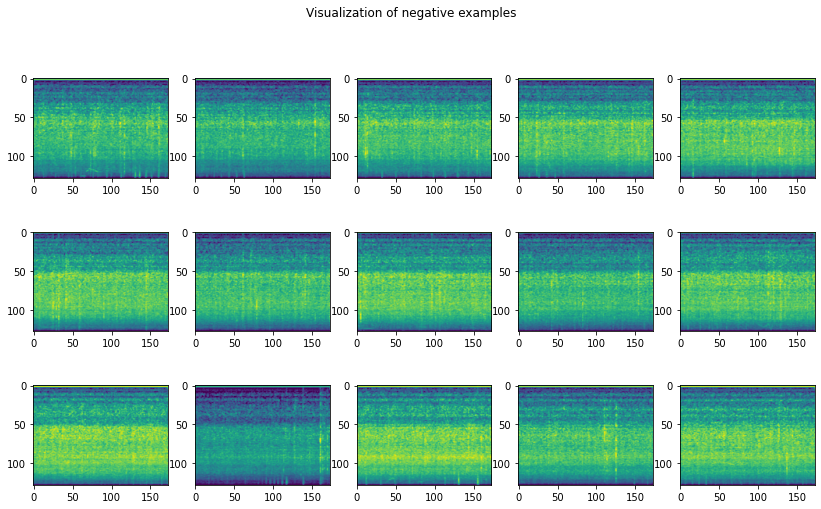

In [135]:
features = []
for i in range(15):
    spec = librosa.feature.melspectrogram(negative_examples[i], sr=sr)
    spec_db = librosa.core.amplitude_to_db(spec)
    features.append(spec_db)

fig, subplots = plt.subplots(3, 5, figsize=(14,8))
for feature, subplot in zip(features, subplots.flatten()):
    subplot.imshow(feature)
    
plt.suptitle('Visualization of negative examples');

In [136]:
mkdir data

In [138]:
import pandas as pd

In [144]:
df = pd.DataFrame({'fn':[f'{fn}.wav' for fn in range(len(positive_examples) + len(negative_examples))], 'label': 'no_call'})
df.head()

,fn,label
0,0.wav,no_call
1,1.wav,no_call
2,2.wav,no_call
3,3.wav,no_call
4,4.wav,no_call


In [145]:
df.label[:len(positive_examples)] = 'call'

In [146]:
df.head()

,fn,label
0,0.wav,call
1,1.wav,call
2,2.wav,call
3,3.wav,call
4,4.wav,call


In [148]:
mkdir data/classification

In [149]:
df.to_csv('data/classification/annotations.csv', index=False)

In [157]:
mkdir data/classification/audio

mkdir: cannot create directory ‘data/classification/audio’: File exists


In [158]:
%%time

for i, rec in enumerate(positive_examples+negative_examples):
    librosa.output.write_wav(f'data/classification/audio/{i}.wav', rec, sr)

CPU times: user 228 ms, sys: 744 ms, total: 972 ms
Wall time: 972 ms


In [160]:
!cd data/classification && zip -1qr orcas_classification.zip annotations.csv audio

## Dataset with annotations as indexes into the audio file

To support the work on the cocktail party problem, and related research, we also share a dataset where calls are labeled as offsets into the audio file.

The only preprocessing we perform here is transforming the annotations into a well-formed csv file.

In [161]:
!mkdir data/offsets
!mkdir data/offsets/audio

In [163]:
ls orcasound-lab/test-only

OS_7_05_2019_08_24_00_labels-old-typos.txt
OS_7_05_2019_08_24_00_labels-SV_200210_only_calls.txt
OS_7_05_2019_08_24_00_labels-SV_200210_other_signals.txt
OS_7_05_2019_08_24_00_.wav


In [164]:
cp orcasound-lab/test-only/OS_7_05_2019_08_24_00_.wav data/offsets/audio/recording.wav

In [173]:
start, end = list(zip(*annotations))

In [ ]:
pd.DataFrame(data={'filename': ['recording.wav'] 'start'})